In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Layer, Dropout, Embedding, Input
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np

In [ ]:
batch_size = 4096

In [ ]:
def load_data(data):
    train_data = {}

    label = data.label.values
    label = label.reshape(len(label), 1)
    train_data['y_train'] = label

    sparse_features = ['C' + str(i) for i in range(1, 27)]
    dense_features = ['I' + str(i) for i in range(1, 14)]

    scaler = MinMaxScaler()
    data[dense_features] = pd.DataFrame(scaler.fit_transform(data[dense_features]), columns=dense_features)

    co_feature = pd.DataFrame()
    ca_feature = pd.DataFrame()

    feat_dict = {}
    cnt = 1
    for col in data.columns:
      if col in dense_features:
          co_feature = pd.concat([co_feature, data[col]], axis=1)
          feat_dict[col] = cnt
          cnt += 1
      elif col in sparse_features:
          us = data[col].unique()
          feat_dict[col] = dict(zip(us, range(cnt, len(us) + cnt)))
          ca_feature = pd.concat([ca_feature, data[col]], axis=1)
          cnt += len(us)

    feat_dim = cnt # 特征的数量
    feature_value = pd.concat([co_feature, ca_feature], axis=1) # 对应特征值，如果是离散特征的话，就是1，如果不是离散特征的话，就保留原来的特征值
    feature_index = feature_value.copy()
    for i in feature_index.columns:
        if i in dense_features:
            feature_index[i] = feat_dict[i]
        else:
            feature_index[i] = feature_index[i].map(feat_dict[i])
            feature_value[i] = 1.
    feature_value = feature_value.fillna(0)
    train_data['xi'] = feature_index.values.astype('int32')
    train_data['xv'] = feature_value.values.astype('float32')
    train_data['feat_dim'] = feat_dim
    return train_data

In [ ]:
def read_file(file_path):
    names = ['label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11',
             'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
             'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22',
             'C23', 'C24', 'C25', 'C26']    

    data = pd.read_csv(file_path, sep='\t', header=None, names=names)
    # data = data.get_chunk(100000)
    return data

In [ ]:
file_path = '/content/drive/MyDrive/ColabNotebooks/RS/wide_deep_model/data/dac_sample.txt'

In [ ]:
df = read_file(file_path)
data = load_data(df)

In [ ]:
data['xi']

array([[     1,      2,      3, ..., 219439, 231774, 231825],
       [     1,      2,      3, ..., 219440, 231774, 231826],
       [     1,      2,      3, ..., 219441, 231775, 231827],
       ...,
       [     1,      2,      3, ..., 221088, 231780, 235037],
       [     1,      2,      3, ..., 219559, 231775, 231827],
       [     1,      2,      3, ..., 219498, 231778, 231901]], dtype=int32)

In [ ]:
data['xv']

array([[1.79856119e-03, 1.61952063e-04, 7.62951095e-05, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.59712238e-03, 1.07968044e-04, 6.71396963e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.59712238e-03, 1.07968044e-04, 1.52590219e-05, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [1.79856122e-02, 2.15936088e-04, 1.52590219e-05, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 2.11617369e-02, 6.56137941e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 5.39840221e-05, 2.09048600e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]], dtype=float32)

In [ ]:
data['xv'][1]

array([3.59712238e-03, 1.07968044e-04, 6.71396963e-04, 2.39808159e-03,
       5.85827111e-05, 4.91098850e-04, 2.27092081e-04, 4.27624560e-04,
       3.15930811e-04, 1.66666672e-01, 9.61538497e-03, 0.00000000e+00,
       6.09942072e-04, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00], dtype=float32)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((data['xi'], data['xv']))
label = tf.data.Dataset.from_tensor_slices(data['y_train'].astype('int32'))
dataset = tf.data.Dataset.zip((dataset, label))
dataset = dataset.shuffle(20000)
dataset = dataset.batch(batch_size)

In [ ]:
train_size = int(0.8 * len(df)/batch_size)
val_size = int(0.2 * len(df)/batch_size)

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

In [ ]:
val_dataset.take(1)

<TakeDataset shapes: (((None, 39), (None, 39)), (None, 1)), types: ((tf.int32, tf.float32), tf.int32)>

In [ ]:
class FM(Layer):
    """
    Wide part
    """

    def __init__(self, feature_length, w_reg=1e-6):
        """
        Factorization Machine
        In DeepFM, only the first order feature and second order feature intersect are included.
        :param feature_length: A scalar. The length of features.
        :param w_reg: A scalar. The regularization coefficient of parameter w.
        """
        super(FM, self).__init__()
        self.feature_length = feature_length
        self.field_size = 39
        self.w_reg = w_reg

    def build(self, input_shape):
        self.w = self.add_weight(name='w', shape=(self.feature_length, 1),
                                 initializer='random_normal',
                                 regularizer=l2(self.w_reg),
                                 trainable=True)

    def call(self, inputs, **kwargs):
        """
        :param inputs: A dict with shape `(batch_size, {'sparse_inputs', 'embed_inputs'})`:
          fea_index is 2D tensor with shape `(batch_size, sum(field_num))` # 
          fea_embed is 3D tensor with shape `(batch_size, fields, embed_dim)` # 
        """
        fea_index, fea_value, fea_embed = inputs['fea_index'], inputs['fea_value'], inputs['fea_embed']
        # first order 一次项，线性模型
        self.embedding_first = tf.nn.embedding_lookup(self.w, fea_index)
        self.embedding_first = tf.multiply(self.embedding_first, tf.reshape(fea_value, [-1, self.field_size, 1]))
        first_order = tf.reduce_sum(self.embedding_first, 1)
        # first_order = tf.reduce_sum(tf.nn.embedding_lookup(self.w, fea_index), axis=1)  # (batch_size, 1)

        # second order 二次项，二阶交叉项
        square_sum = tf.square(tf.reduce_sum(fea_embed, axis=1, keepdims=True))  # (batch_size, 1, embed_dim)
        sum_square = tf.reduce_sum(tf.square(fea_embed), axis=1, keepdims=True)  # (batch_size, 1, embed_dim)
        second_order = 0.5 * tf.reduce_sum(square_sum - sum_square, axis=2)  # (batch_size, 1)
        return first_order + second_order


class DNN(Layer):
    """
    Deep part
    """

    def __init__(self, hidden_units, activation='relu', dnn_dropout=0.2):
        """
        DNN part
        :param hidden_units: A list like `[unit1, unit2,...,]`. List of hidden layer units's numbers
        :param activation: A string. Activation function.
        :param dnn_dropout: A scalar. dropout number.
        """
        super(DNN, self).__init__()
        self.dnn_network = [Dense(units=unit, activation=activation) for unit in hidden_units]
        self.dropout = Dropout(dnn_dropout)

    def call(self, inputs, **kwargs):
        x = inputs
        for dnn in self.dnn_network:
            x = dnn(x)
        x = self.dropout(x)
        return x

In [ ]:
class DeepFM(Model):
    def __init__(self, train_data, hidden_units=(128, 64), dnn_dropout=0.3,
                 activation='relu', fm_w_reg=1e-6, embed_reg=1e-6):
        """
        DeepFM
        :param feature_columns: A list. sparse column feature information.
        :param hidden_units: A list. A list of dnn hidden units.
        :param dnn_dropout: A scalar. Dropout of dnn.
        :param activation: A string. Activation function of dnn.
        :param fm_w_reg: A scalar. The regularizer of w in fm.
        :param embed_reg: A scalar. The regularizer of embedding.
        """
        super(DeepFM, self).__init__()
        self.train_data = train_data
        # 二阶（FM）与高阶（DNN）的特征交互，共享embedding矩阵
        self.embed_layers = tf.keras.layersEmbedding(input_dim=self.train_data['feat_dim'],
                                      input_length=1,
                                      output_dim=4,
                                      embeddings_initializer='random_normal',
                                      embeddings_regularizer=l2(embed_reg))

        self.fm = FM(self.train_data['feat_dim'], fm_w_reg)
        self.dnn = DNN(hidden_units, activation, dnn_dropout)
        self.dense = Dense(1, activation=None)

    def call(self, inputs, **kwargs):
        fea_index, fea_value = inputs
        # embedding
        fea_embed = self.embed_layers(fea_index)  # (batch_size, embed_dim * fields) FM和DNN共享的特征embedding
        # wide
        wide_inputs = {'fea_index': fea_index,
                 'fea_value': fea_value,
                 'fea_embed': fea_embed}
        wide_outputs = self.fm(wide_inputs)  # (batch_size, 1)

        fea_embed = tf.reshape(fea_embed, shape=(-1, fea_embed.shape[1] * fea_embed.shape[2])) # concat feature embedding
        
        # deep
        deep_outputs = self.dnn(fea_embed)
        deep_outputs = self.dense(deep_outputs)  # (batch_size, 1)
        # outputs
        outputs = tf.nn.sigmoid(tf.add(wide_outputs, deep_outputs))
        return outputs

In [ ]:
model = DeepFM(data, dnn_dropout=0.5)

In [ ]:
model.compile(loss=binary_crossentropy, optimizer=Adam(0.0001), metrics=[AUC()])

In [ ]:
epochs = 160

In [ ]:
history = model.fit(train_dataset, batch_size=batch_size, epochs=epochs, validation_data = val_dataset)

Epoch 1/160
19/19 [==============================] - 2s 67ms/step - loss: 0.6649 - auc_2: 0.4973 - val_loss: 0.6511 - val_auc_2: 0.4954
Epoch 2/160
19/19 [==============================] - 1s 48ms/step - loss: 0.6327 - auc_2: 0.5111 - val_loss: 0.6217 - val_auc_2: 0.5012
Epoch 3/160
19/19 [==============================] - 1s 48ms/step - loss: 0.6051 - auc_2: 0.5222 - val_loss: 0.5942 - val_auc_2: 0.5204
Epoch 4/160
19/19 [==============================] - 1s 48ms/step - loss: 0.5796 - auc_2: 0.5339 - val_loss: 0.5742 - val_auc_2: 0.5333
Epoch 5/160
19/19 [==============================] - 1s 48ms/step - loss: 0.5590 - auc_2: 0.5446 - val_loss: 0.5567 - val_auc_2: 0.5417
Epoch 6/160
19/19 [==============================] - 1s 49ms/step - loss: 0.5431 - auc_2: 0.5595 - val_loss: 0.5433 - val_auc_2: 0.5515
Epoch 7/160
19/19 [==============================] - 1s 50ms/step - loss: 0.5340 - auc_2: 0.5702 - val_loss: 0.5404 - val_auc_2: 0.5716
Epoch 8/160
19/19 [=============================

In [ ]:
model.summary()

Model: "deep_fm_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  965408    
_________________________________________________________________
fm_2 (FM)                    multiple                  241352    
_________________________________________________________________
dnn_2 (DNN)                  multiple                  28352     
_________________________________________________________________
dense_8 (Dense)              multiple                  65        
Total params: 1,235,177
Trainable params: 1,235,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keys_list = list(history.history.keys())

In [ ]:
keys_list

['loss', 'auc_2', 'val_loss', 'val_auc_2']

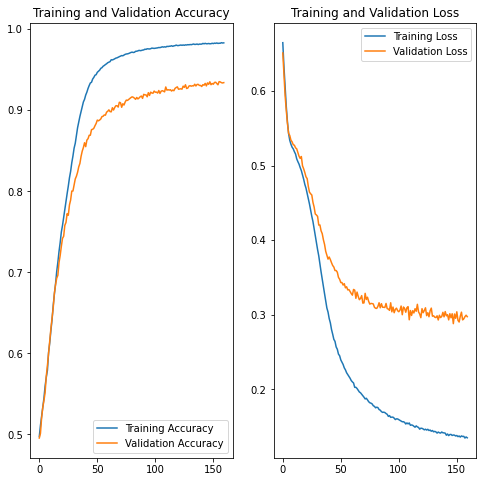

In [ ]:
import matplotlib.pyplot as plt

acc = history.history[keys_list[1]]
val_acc = history.history[keys_list[3]]

loss = history.history[keys_list[0]]
val_loss = history.history[keys_list[2]]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()